# Anomaly Detection using LSTM in S&P data

Import Libraries

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

sns.set(style='whitegrid', palette='muted')
rcParams['figure.figsize'] = 16, 6 # set figsize for all images

np.random.seed(1)
tf.random.set_seed(1)

print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.15.0


load data and check

In [ ]:
df = pd.read_csv('S&P_500_Index_Data.csv',parse_dates=['date'])
df.head()

,date,close
0,1986-01-02,209.59
1,1986-01-03,210.88
2,1986-01-06,210.65
3,1986-01-07,213.80
4,1986-01-08,207.97


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8192 entries, 0 to 8191
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    8192 non-null   datetime64[ns]
 1   close   8192 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 128.1 KB


In [ ]:
# using Plotly (visual elements)

fig = go.Figure()
fig.add_trace(go.Scatter(x=df['date'],y=df['close'],mode='lines',name='close')) # lines mode for lineplot
fig.update_layout(title='S&P 500',xaxis_title="Time",yaxis_title='INDEXSP',showlegend=True)
fig.show()



```
data preprocessing
```



In [ ]:
train_size = int(len(df) * 0.8) # 80% size for training set
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:]

In [ ]:
print(train.shape,test.shape)

(6553, 2) (1639, 2)


Normalizing the data

In [ ]:
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler()
scalar = scalar.fit(train[['close']])

train['close'] = scalar.transform(train[['close']])
test['close'] = scalar.transform(test[['close']])

Create Training and Test Splits

In [ ]:
def create_sequences(X, y, time_steps=1):                           # desired length of the sequences to be created
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values#predict the target value by the preceding sequence of features
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [ ]:
time_steps = 30

X_train, y_train = create_sequences(train[['close']],train['close'],time_steps)
X_test, y_test = create_sequences(test[['close']],test['close'],time_steps)

In [ ]:
print(X_train.shape,y_train.shape)

(6523, 30, 1) (6523,)


Build an LSTM Autoencoder

In [ ]:
timesteps = X_train.shape[1]
num_features = X_train.shape[2]

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

model = Sequential()
model.add(LSTM(128,input_shape=(timesteps,num_features)))#memory cell
model.add(Dropout(0.2))
model.add(RepeatVector(timesteps)) # Repeats the input n times.
model.add(LSTM(128,return_sequences=True)) # return the entire output sequence
model.add(Dropout(0.2))
model.add(TimeDistributed(Dense(num_features)))#output units

model.compile(loss='mae',optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 repeat_vector (RepeatVecto  (None, 30, 128)           0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 30, 128)           0         
                                                                 
 time_distributed (TimeDist  (None, 30, 1)             129       
 ributed)                                               

Train the Autoencoder

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=3,mode='min')

In [ ]:
history = model.fit(X_train,y_train,epochs=100,batch_size=32,validation_split=0.1,callbacks=[early_stop],shuffle=False)

Train on 5870 samples, validate on 653 samples
Epoch 1/100
5870/5870 [==============================] - 39s 7ms/sample - loss: 0.1625 - val_loss: 0.1610
Epoch 2/100
5870/5870 [==============================] - 35s 6ms/sample - loss: 0.1114 - val_loss: 0.0986
Epoch 3/100
5870/5870 [==============================] - 31s 5ms/sample - loss: 0.0903 - val_loss: 0.0443
Epoch 4/100
5870/5870 [==============================] - 31s 5ms/sample - loss: 0.0802 - val_loss: 0.0442
Epoch 5/100
5870/5870 [==============================] - 34s 6ms/sample - loss: 0.0717 - val_loss: 0.0618
Epoch 6/100
5870/5870 [==============================] - 33s 6ms/sample - loss: 0.0774 - val_loss: 0.0326
Epoch 7/100
5870/5870 [==============================] - 33s 6ms/sample - loss: 0.0751 - val_loss: 0.0309
Epoch 8/100
5870/5870 [==============================] - 30s 5ms/sample - loss: 0.0745 - val_loss: 0.0590
Epoch 9/100
5870/5870 [==============================] - 31s 5ms/sample - loss: 0.0759 - val_loss: 0.0533

In [ ]:
# saving model for later use
model.save('anomaly_model.h5')

Plot Metrics and Evaluate the Model

In [ ]:
# Load our saved model
history = tf.keras.models.load_model('anomaly_model.h5')

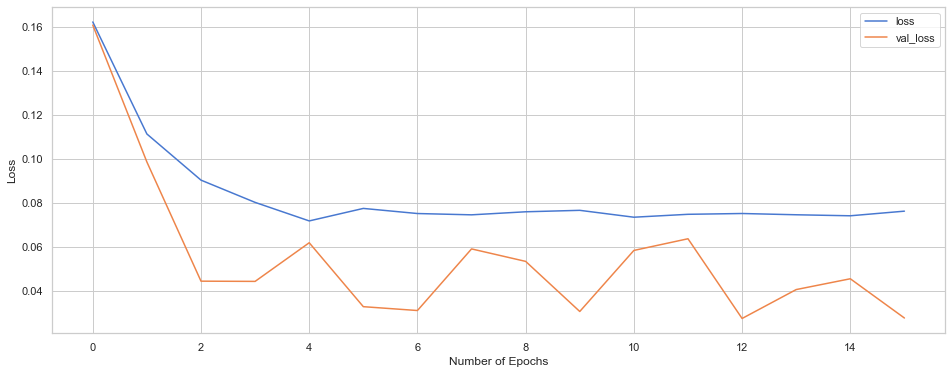

In [ ]:
err = pd.DataFrame(history.history)
err.plot()
plt.xlabel('Number of Epochs')
plt.ylabel('Loss');

In [ ]:
#As our val_loss < loss , we underfit on the training data probably because of the high dropout rate.

In [ ]:
# Calculating the mae for training data
X_train_pred = model.predict(X_train)
train_mae_loss = pd.DataFrame(np.mean(np.abs(X_train_pred - X_train),axis=1),columns=['Error'])

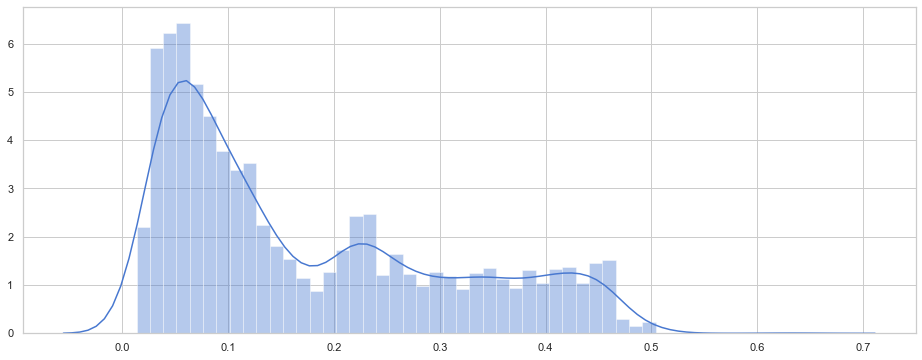

In [ ]:
sns.distplot(train_mae_loss,bins=50,kde=True); # Plot histogram of traning losses

As we see there are almost no observations which have training loss more than 0.65

In [ ]:
threshold = 0.65

if we notice a error > threshold, we will say that it is an anamoly

In [ ]:
# Calculate mae for test data
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test),axis=1)

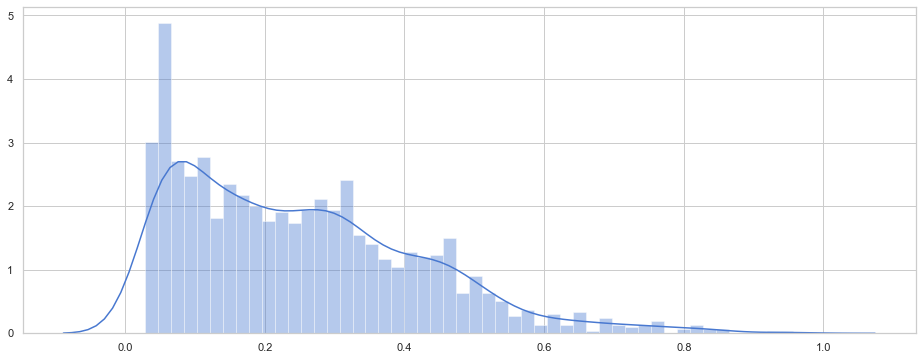

In [ ]:
sns.distplot(test_mae_loss, bins=50, kde=True); # Plot histogram of test losses

Detect Anomalies

In [ ]:
test_score_df = pd.DataFrame(test[time_steps:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
test_score_df['close'] = test[time_steps:]['close']

In [ ]:
test_score_df.head()

,date,close,loss,threshold,anomaly
6583,2012-02-08,1.216856,0.095959,0.65,False
6584,2012-02-09,1.221625,0.095036,0.65,False
6585,2012-02-10,1.199313,0.092616,0.65,False
6586,2012-02-13,1.221194,0.074943,0.65,False
6587,2012-02-14,1.218150,0.076545,0.65,False


In [ ]:
test_score_df.tail()

,date,close,loss,threshold,anomaly
8187,2018-06-25,4.493228,0.635811,0.65,False
8188,2018-06-26,4.507583,0.688552,0.65,True
8189,2018-06-27,4.451431,0.693630,0.65,True
8190,2018-06-28,4.491406,0.724405,0.65,True
8191,2018-06-29,4.496343,0.706576,0.65,True


In [ ]:
anomalies = test_score_df[test_score_df['anomaly']==True]
anomalies.head()

,date,close,loss,threshold,anomaly
7475,2015-08-26,2.632149,0.706212,0.65,True
8090,2018-02-05,4.329949,0.654741,0.65,True
8091,2018-02-06,4.440671,0.842731,0.65,True
8092,2018-02-07,4.408365,0.818987,0.65,True
8093,2018-02-08,4.167127,0.814940,0.65,True
